<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
# Проверим пустые значения
for col in data.columns:
  print(col, len(data[data[col] == " "]))

ClientPeriod 0
MonthlySpending 0
TotalSpent 9
Sex 0
IsSeniorCitizen 0
HasPartner 0
HasChild 0
HasPhoneService 0
HasMultiplePhoneNumbers 0
HasInternetService 0
HasOnlineSecurityService 0
HasOnlineBackup 0
HasDeviceProtection 0
HasTechSupportAccess 0
HasOnlineTV 0
HasMovieSubscription 0
HasContractPhone 0
IsBillingPaperless 0
PaymentMethod 0
Churn 0


In [6]:
# В столбце TotalSpent были пустые строки, что мешало конвертации в тип float
data[data["TotalSpent"] == " "]  = np.nan
data["TotalSpent"] = data["TotalSpent"].astype(float)

# Данное кол-во наблюдений можно удалить из датасета
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# Лучше перевести IsSeniorCitizen в категориальный тип с float
data["IsSeniorCitizen"] = data["IsSeniorCitizen"].apply(lambda x: "Yes" if x==1 else "No" )

В столбце TotalSpent есть пустые строки, их 9. Данное кол-во наблюдений можно удалить из датасета

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).




Графики для ClientPeriod


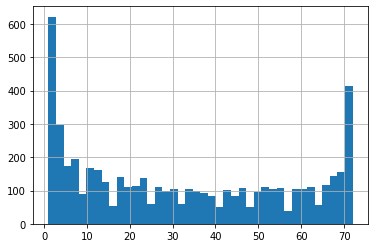

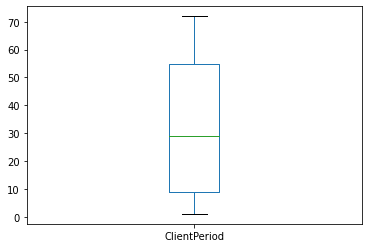




Графики для MonthlySpending


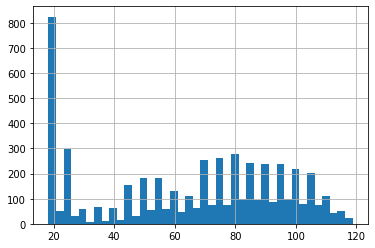

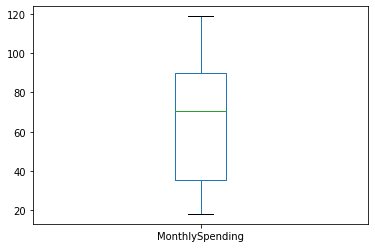




Графики для TotalSpent


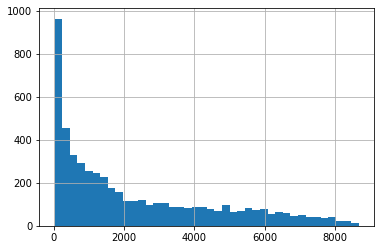

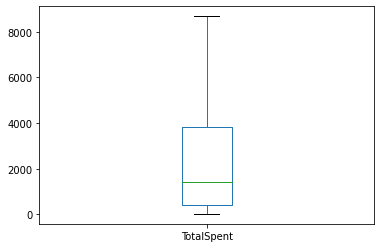

In [8]:
for col_name in num_cols:
  print(f"\n\n\nГрафики для {col_name}")
  data[col_name].hist(bins=40)
  plt.show()
  data[col_name].plot(kind="box")
  plt.show()




Графики для Sex


Male      2651
Female    2622
Name: Sex, dtype: int64

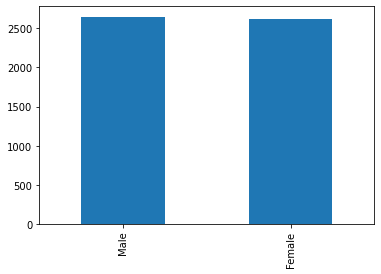

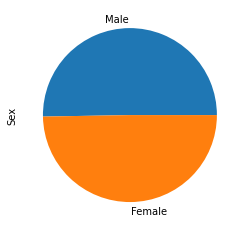




Графики для IsSeniorCitizen


No     4431
Yes     842
Name: IsSeniorCitizen, dtype: int64

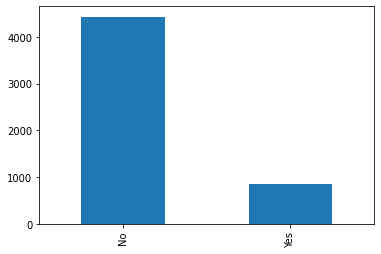

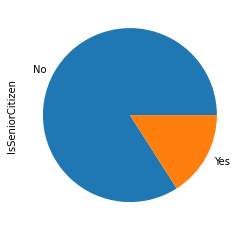




Графики для HasPartner


No     2704
Yes    2569
Name: HasPartner, dtype: int64

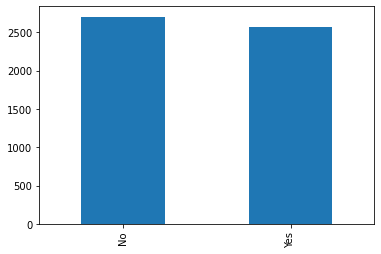

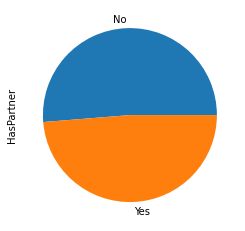




Графики для HasChild


No     3676
Yes    1597
Name: HasChild, dtype: int64

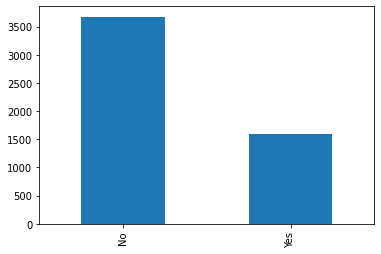

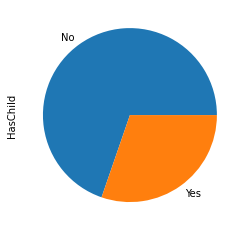




Графики для HasPhoneService


Yes    4754
No      519
Name: HasPhoneService, dtype: int64

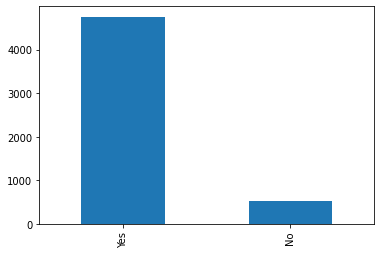

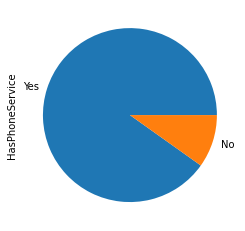




Графики для HasMultiplePhoneNumbers


No                  2508
Yes                 2246
No phone service     519
Name: HasMultiplePhoneNumbers, dtype: int64

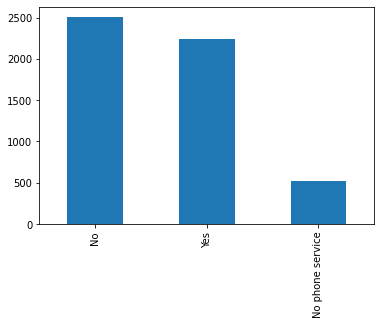

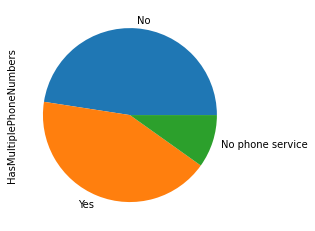




Графики для HasInternetService


Fiber optic    2341
DSL            1795
No             1137
Name: HasInternetService, dtype: int64

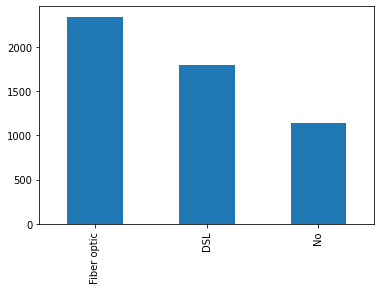

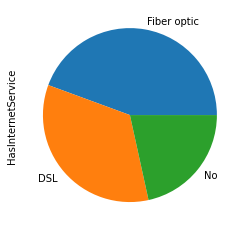




Графики для HasOnlineSecurityService


No                     2611
Yes                    1525
No internet service    1137
Name: HasOnlineSecurityService, dtype: int64

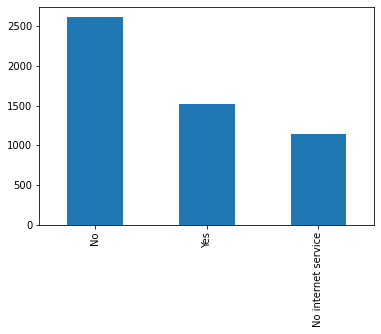

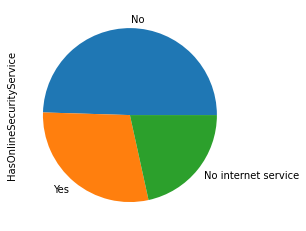




Графики для HasOnlineBackup


No                     2331
Yes                    1805
No internet service    1137
Name: HasOnlineBackup, dtype: int64

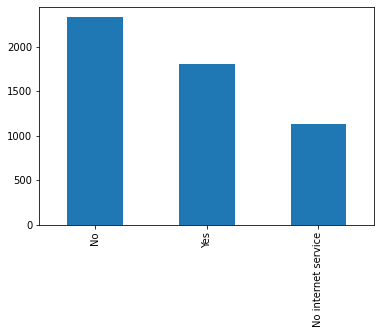

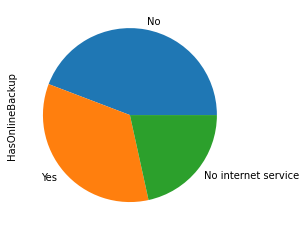




Графики для HasDeviceProtection


No                     2316
Yes                    1820
No internet service    1137
Name: HasDeviceProtection, dtype: int64

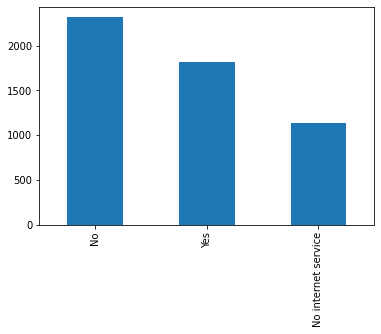

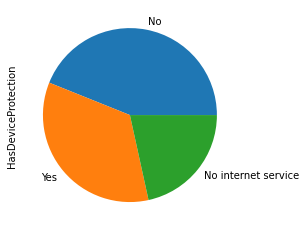




Графики для HasTechSupportAccess


No                     2603
Yes                    1533
No internet service    1137
Name: HasTechSupportAccess, dtype: int64

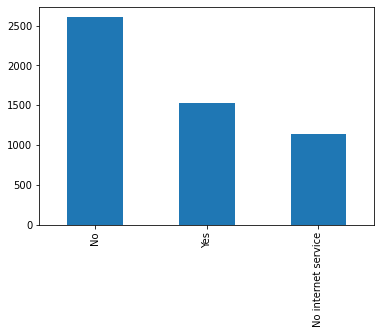

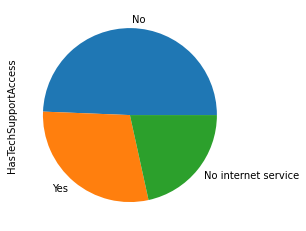




Графики для HasOnlineTV


No                     2098
Yes                    2038
No internet service    1137
Name: HasOnlineTV, dtype: int64

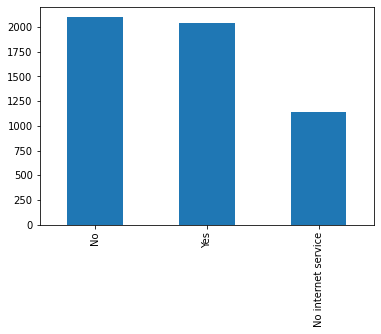

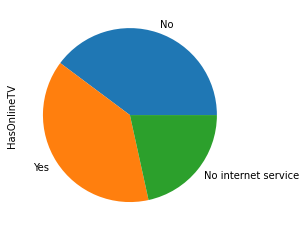




Графики для HasMovieSubscription


No                     2077
Yes                    2059
No internet service    1137
Name: HasMovieSubscription, dtype: int64

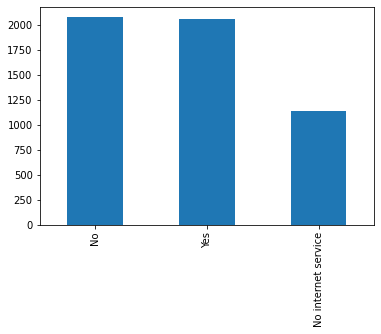

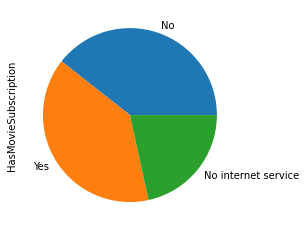




Графики для HasContractPhone


Month-to-month    2920
Two year          1272
One year          1081
Name: HasContractPhone, dtype: int64

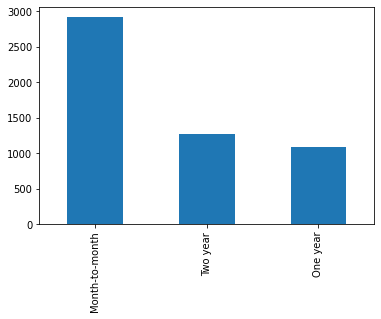

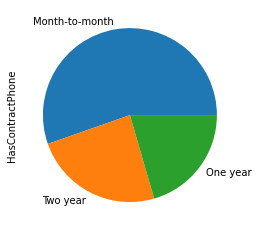




Графики для IsBillingPaperless


Yes    3145
No     2128
Name: IsBillingPaperless, dtype: int64

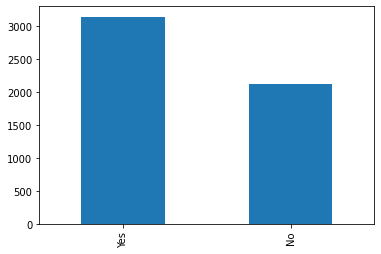

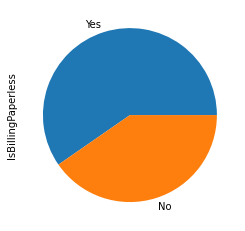




Графики для PaymentMethod


Electronic check             1786
Mailed check                 1188
Bank transfer (automatic)    1157
Credit card (automatic)      1142
Name: PaymentMethod, dtype: int64

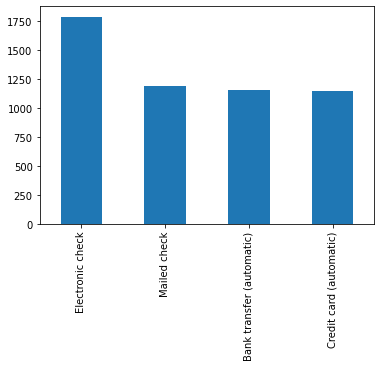

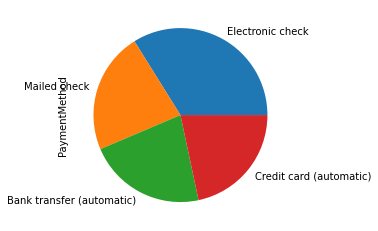

In [9]:
def data_plot(series):
  stats = series.value_counts()
  
  display(stats)
  stats.plot(kind="bar")
  plt.show()
  stats.plot(kind="pie")
  plt.show()

for col_name in cat_cols:
  print(f"\n\n\nГрафики для {col_name}")
  data_plot(data[col_name])

0.0    3889
1.0    1384
Name: Churn, dtype: int64

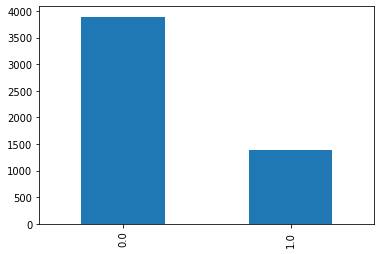

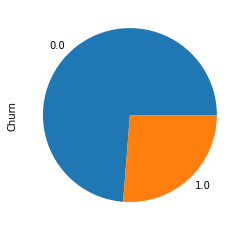

In [10]:
data_plot(data[target_col])

In [ ]:
Данные в целевой переменной не являются сбалансированными, но не критично. Положительного класса в 3 раза меньше отрицательного.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [514]:
# Пробовал перевести переменные ClientPeriod и MonthlySpending в категориальные переменные. Сильного улучшения качества не принесло.

# data["10_client_period"] = (data["ClientPeriod"] <= 10) * 1
# data["10_client_period"] = data["10_client_period"].apply(lambda x: "Yes" if x==1 else "No" )

# data["more_60_client_period"] = (data["ClientPeriod"] >= 60) * 1
# data["more_60_client_period"] = data["more_60_client_period"].apply(lambda x: "Yes" if x==1 else "No" )

# # data["less_1000_TotalSpent"] = (data["TotalSpent"] <= 1000) * 1
# # data["less_1000_TotalSpent"] = data["less_1000_TotalSpent"].apply(lambda x: "Yes" if x==1 else "No" )

# # data["less_25_MonthlySpending"] = (data["MonthlySpending"] <= 25) * 1
# # data["less_25_MonthlySpending"] = data["less_25_MonthlySpending"].apply(lambda x: "Yes" if x==1 else "No" )

# cat_cols = cat_cols + ["10_client_period", "more_60_client_period",
#                       #  "less_1000_TotalSpent","less_25_MonthlySpending"
#                        ]

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [11]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [12]:
my_scaler = RobustScaler() # Попробовал MinMaxScaler, StandardScaler и RobustScaler, лучшим оказался RobustScaler
std_num_data = pd.DataFrame(my_scaler.fit_transform(data[num_cols]), columns=data[num_cols].columns)
enc_cat_data = pd.get_dummies(data[cat_cols], drop_first=True)
preccesed_data = pd.concat([std_num_data,enc_cat_data], axis=1)
# preccesed_data.drop(["ClientPeriod"], axis=1, inplace=True)
preccesed_data

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Male,IsSeniorCitizen_Yes,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.565217,-0.934005,-0.112705,1,0,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1
1,0.934783,-0.817599,0.135618,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0
2,-0.608696,0.099908,-0.391736,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.065217,0.162236,0.340477,0,1,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.673913,0.821265,1.570114,0,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,-0.565217,-0.734189,-0.389901,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5269,0.456522,-0.476627,0.228462,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
5270,-0.608696,-0.282310,-0.397857,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
5271,0.000000,0.101742,0.236330,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(preccesed_data, data[target_col], train_size=0.8, random_state=77)

In [466]:
# Пробовал отбирать переменные, по важности. Сильного улучшения не принесло.

# from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)

# # pd.Series(clf.feature_importances_, index=X_train.columns).plot.bar(color='steelblue', figsize=(12, 6))
# dt_fatures = pd.Series(clf.feature_importances_, index=X_train.columns)[:10].index
# X_train = X_train[dt_fatures]
# X_test = X_test[dt_fatures]

In [29]:
# Обучение модели Логистической регрессии
selected_features = X_train.columns

fold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

logit_reg = LogisticRegressionCV(
    penalty="l2",
    scoring='roc_auc',
    Cs=list(np.power(10.0, np.arange(-10, 10))), 
    n_jobs=-1,
    max_iter=15000,
    cv=fold,
    refit=True,
    class_weight="balanced",
    solver="liblinear",
    tol=0.0002,
    random_state=42
    )
logit_reg.fit(X_train, y_train)

print("Коэффициенты модели:")
display(pd.Series(logit_reg.coef_[0], index=X_train.columns))
print(f"\nC: {logit_reg.C_[0]}")
print('\nMax train auc_roc:', logit_reg.scores_[1].max())
print('Max test auc_roc:', roc_auc_score(y_test, logit_reg.predict_proba(X_test)[:,1]))

Коэффициенты модели:


ClientPeriod                                   -2.881147
MonthlySpending                                -4.377179
TotalSpent                                      1.302868
Sex_Male                                       -0.055658
IsSeniorCitizen_Yes                             0.210026
HasPartner_Yes                                  0.001014
HasChild_Yes                                   -0.189225
HasPhoneService_Yes                            -0.513762
HasMultiplePhoneNumbers_No phone service       -1.529362
HasMultiplePhoneNumbers_Yes                     0.634423
HasInternetService_Fiber optic                  2.576288
HasInternetService_No                          -0.435552
HasOnlineSecurityService_No internet service   -0.435552
HasOnlineSecurityService_Yes                   -0.089931
HasOnlineBackup_No internet service            -0.435552
HasOnlineBackup_Yes                             0.184138
HasDeviceProtection_No internet service        -0.435552
HasDeviceProtection_Yes        


C: 100.0

Max train auc_roc: 0.8645140098826084
Max test auc_roc: 0.8506853904099667


In [39]:
# Обучение нейронной сети
import tensorflow as tf
from tensorflow import keras

my_callbacks = [keras.callbacks.EarlyStopping(patience=10),
                keras.callbacks.ModelCheckpoint(
                    filepath='best_model.h5',
                    monitor='val_auc',
                    save_weights_only=True,
                    mode='max',
                    save_best_only=True)
]

nn_model = keras.Sequential([
    keras.layers.Dense(30, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


nn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['AUC'],)

nn_model.fit(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             verbose=1,
             callbacks=my_callbacks)

nn_model.load_weights("best_model.h5")

Epoch 1/100
132/132 [==============================] - 1s 5ms/step - loss: 0.4477 - auc: 0.8110 - val_loss: 0.4320 - val_auc: 0.8368
Epoch 2/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4195 - auc: 0.8388 - val_loss: 0.4205 - val_auc: 0.8477
Epoch 3/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4150 - auc: 0.8429 - val_loss: 0.4172 - val_auc: 0.8503
Epoch 4/100
132/132 [==============================] - 0s 2ms/step - loss: 0.4105 - auc: 0.8468 - val_loss: 0.4154 - val_auc: 0.8503
Epoch 5/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4077 - auc: 0.8493 - val_loss: 0.4199 - val_auc: 0.8475
Epoch 6/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4057 - auc: 0.8512 - val_loss: 0.4130 - val_auc: 0.8517
Epoch 7/100
132/132 [==============================] - 0s 2ms/step - loss: 0.4039 - auc: 0.8522 - val_loss: 0.4217 - val_auc: 0.8482
Epoch 8/100
132/132 [==============================] - 0s 2ms/step - 

In [40]:
nn_prediction = nn_model.predict_proba(X_test)
print('Max test auc_roc:', roc_auc_score(y_test, nn_prediction))

Max test auc_roc: 0.8517899826162538


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [41]:
!pip install catboost

     |████████████████████████████████| 66.2MB 63kB/s 


In [44]:
from catboost import CatBoostClassifier, Pool, cv

X_train, X_test, y_train, y_test = train_test_split(data.drop([target_col],axis=1), data[target_col], 
                                                    test_size=0.1, random_state=77)

best_cat_model = None
best_auc = float("-inf")

for lr in [0.1, 0.01]:
  for num_trees in [100, 500, 1000]:
    cat_model = CatBoostClassifier(num_trees=num_trees,
                                   learning_rate=lr,
                                   verbose=0,
                                   random_seed=77,
                                   eval_metric='AUC',
                                   use_best_model=True)
    cat_train = Pool(data = X_train, label = y_train, 
                              cat_features = cat_cols, feature_names = feature_cols)
    cat_model.fit(cat_train, eval_set = (X_test, y_test))
    
    # Predict
    preds_class = cat_model.predict_proba(X_test)[:,1]
    metric = roc_auc_score(y_test, preds_class)
    print(f"lr:{lr}, num_trees: {num_trees}, roc: {metric}")
    
    # Check best model
    if metric > best_auc:
      best_cat_model = cat_model
      best_auc = metric

lr:0.1, num_trees: 100, roc: 0.8568250868055556
lr:0.1, num_trees: 500, roc: 0.8583984375
lr:0.1, num_trees: 1000, roc: 0.8583984375
lr:0.01, num_trees: 100, roc: 0.8220486111111112
lr:0.01, num_trees: 500, roc: 0.8565719039351851
lr:0.01, num_trees: 1000, roc: 0.8565719039351851


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Лучшее качество получилось roc:0.8583984375 с параметрами lr:0.1, num_trees: 500 

# Предсказания

In [45]:
best_model = best_cat_model

In [46]:
def data_proccess(df, scaler, num_cols, cat_cols):
  df[df["TotalSpent"] == " "]  = 0
  df["TotalSpent"] = df["TotalSpent"].astype(float)
  df["IsSeniorCitizen"] = df["IsSeniorCitizen"].apply(lambda x: "Yes" if x==1 else "No" )
  preccesed_data = df

  # df["10_client_period"] = (df["ClientPeriod"] <= 10) * 1
  # df["10_client_period"] = df["10_client_period"].apply(lambda x: "Yes" if x==1 else "No" )
  # df["more_60_client_period"] = (df["ClientPeriod"] >= 60) * 1
  # df["more_60_client_period"] = df["more_60_client_period"].apply(lambda x: "Yes" if x==1 else "No" )

  # std_num_data = pd.DataFrame(scaler.transform(df[num_cols]), columns=df[num_cols].columns)
  # enc_cat_data = pd.get_dummies(df[cat_cols])
  # preccesed_data = pd.concat([std_num_data, enc_cat_data], axis=1)

  # preccesed_data.drop("ClientPeriod", axis=1, inplace=True)
  return preccesed_data

In [47]:
X_test = pd.read_csv('./test.csv')
X_test = data_proccess(X_test, my_scaler, num_cols, cat_cols)
# X_test = X_test[selected_features]
X_test

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,No,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,No,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.40,Female,No,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.60,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555.00,Female,No,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1758,2,91.45,171.45,Male,No,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.80,Female,No,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


In [49]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] =  best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.